In [141]:
%load_ext autoreload
%autoreload 3

import numpy as np
import pandas as pd
from joblib import delayed, Parallel
from numba import njit
from tqdm import tqdm
import time
from itertools import permutations, combinations

import sys
sys.path.append("../..")

from tetrahedron import tetrahedron, proj_quality
from metric.metric import Euclid

import pivot_selection
from generate import point_generator

import matplotlib.pyplot as plt
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [160]:
dims = 10
n_points = 1000
n_piv_candidates = 300
n_pivs_required = 10
budget = 4*n_points
metric = pivot_selection.lb_summation.METRIC

rng = np.random.default_rng(0xABACADABA)

data = point_generator.generate_univar_points(rng, n_points, dim=dims)
tri_pivots = pivot_selection.lb_summation.IS_multiple(data, n_piv_candidates, budget, rng, "tri",n_pivs_required)
trai_pivots = rng.choice(data, size=n_pivs)
pto_pivots = pivot_selection.lb_summation.IS(data, n_piv_candidates, budget, rng, "pto")

62210.72342099306
72601.4611251979
79887.23318066014
85483.74338099897
89769.83832424309
93387.08008669555
96338.0998244441
98702.16162477872
100715.14611267591
[215, 246, 87, 222, 115, 150, 250, 142, 95, 201]
(300, 10)


In [155]:
tri_pivots

array([[-15.01605166, -16.59990956,  10.0614509 ,  -5.8462711 ,
        -17.81159327,   8.56192719, -17.29587169,  13.38124171,
         -5.97496247, -15.93903475],
       [ -3.3024298 ,  14.67427579,   7.8659956 ,   1.17072492,
         18.380428  ,  16.17506961,  14.98501303,   6.79177106,
         11.28092096, -14.70269438],
       [-14.65444905,   1.85984324, -15.98132648, -15.81412302,
          8.9784309 , -16.6810879 ,  11.21017455,  15.16234109,
         -6.54952322,  14.49834637],
       [ 16.8554387 ,  18.0256139 ,  -0.94819343, -18.44881966,
         14.2154565 , -17.48002927, -13.73503607, -14.05390968,
          9.7137847 ,   0.40642746],
       [ 15.91281443, -12.52273428, -11.23639677, -17.05099458,
        -17.59329145,   9.33227119,  13.48009934,  -9.56589157,
         13.52873786,   6.12078438],
       [  6.11572555,  -8.8418081 ,  17.94063533,   9.3572961 ,
         -1.59126482,  17.83283501,  -1.86974665,  17.96802086,
        -10.03830938,  16.68747685],
       [  

In [143]:
triu = np.triu_indices(n_points,1)
actual_dists = metric.distance_matrix(data,data)[triu]

In [137]:
def get_best_tri_lbs(pivots, data):
    def tri_lb_all_pairs_dist(pivots, data):
        for p in pivots:
            d_c = metric(p, data)
            lbs_tri = np.abs(d_c.reshape(-1,1) - d_c.reshape(1,-1))
            yield lbs_tri[triu]
    
    all_lbs = np.stack(list(tri_lb_all_pairs_dist(pivots, data)))
    best_lbs = np.amax(all_lbs, axis=0)
    return best_lbs


best_tri_tri_lbs = get_best_tri_lbs(tri_pivots, data)
best_pto_tri_lbs = get_best_tri_lbs(pto_pivots, data)

In [138]:
@njit
def pto_all_pairs(d1, d2, piv_piv_dist):
    n = len(d1)
    dist_matrix = np.zeros((n,n))
    
    for q in range(n):
        for x in range(n):
            dist_matrix[q,x] = d1[q]*d2[x] - d1[x]*d2[q]
    
    dist_matrix = 1/piv_piv_dist * np.abs(dist_matrix)
    return dist_matrix
            

def get_best_pto_lbs(pivots, data):
    def lb_all_pairs_dist(pivots, data):
        for p1,p2 in combinations(pivots,2):
            d1 = metric(p1, data)
            d2 = metric(p2, data)
            quotient = metric(p1, p2) 
            lbs = pto_all_pairs(d1, d2, quotient)
            yield lbs[triu]
    
    all_lbs = np.stack(list(lb_all_pairs_dist(pivots, data)))
    best_lbs = np.amax(all_lbs, axis=0)
    return best_lbs


best_tri_pto_lbs = get_best_pto_lbs(tri_pivots, data)
best_pto_pto_lbs = get_best_pto_lbs(pto_pivots, data)

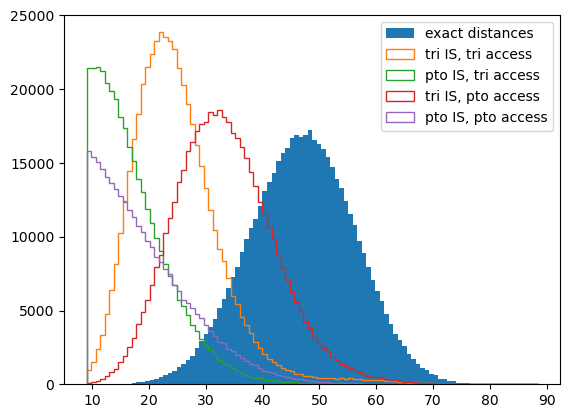

In [139]:
#distances_from_pivot
# cached distances

def histogram_overlap(data_a, data_b, bins=50):
    both = np.hstack((data_a, data_b))
    bins = np.histogram_bin_edges(both, bins=bins)
    a, _ = np.histogram(data_a, bins)
    b, _ = np.histogram(data_b, bins)
    overlap_absolute = np.vstack((a, b)).min(axis=0).sum()
    bin_width = bins[1] - bins[0]
    return overlap_absolute / len(data_a)

_, bins, _ = plt.hist(actual_dists, bins=100, label="exact distances")
plt.hist(best_tri_tri_lbs, histtype="step", bins=bins, label="tri IS, tri access");
plt.hist(best_pto_tri_lbs, histtype="step", bins=bins, label="pto IS, tri access");
plt.hist(best_tri_pto_lbs, histtype="step", bins=bins, label="tri IS, pto access");
plt.hist(best_pto_pto_lbs, histtype="step", bins=bins, label="pto IS, pto access");

plt.legend()

In [140]:
histogram_overlap(actual_dists, best_tri_tri_lbs)

np.float64(0.1871071071071071)

In [127]:
histogram_overlap(actual_dists, best_pto_tri_lbs)

np.float64(0.07854054054054053)

In [128]:
histogram_overlap(actual_dists, best_pto_pto_lbs)

np.float64(0.1102882882882883)